# Simulating Dust Observations

This notebook is meant to provide the scaffolding for us to explore simulating 2-D and 3-D observations of dust, along with the associated observational effects that go along with it.

We will first go through the basic underlying model and how to simulate noiseless, true values. There will also be empty sections where we will plan to add in additional levels of complexity.

# Preamble

Setting up some basic imports. The big one that is non-standard is [scikit-learn](scikit-learn.org), which implements a lot of basic machine learning (ML) methods in Python in an easy-to-use way.

In [1]:
# standard imports
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import sklearn

# plot in-line within the notebook
%matplotlib inline

In [2]:
# these modify the default plotting options
# feel free to ignore these or you can play around with
# adjusting things on your own
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Baseline Model: Log-Gaussian Process

Our baseline model is that the logarithm of the dust density $\log \rho(\mathbf{x})$  (unless otherwise specified, $\log$ is always base-$e$ not base-10) as a function of position $\mathbf{x} = \{x,y,z\}$ is distributed following a **Gaussian Process** (GP). If you haven't come across GPs before, there is a really great overview of them [**here**](https://distill.pub/2019/visual-exploration-gaussian-processes/) that we can go over together. The tl;dr is it provides a way to generate random data realizations with a specific mean and covariance structure. So data will tend to follow certain overall trends and correlations [based on kernel and training data im guessing] while still allowing for some degree of randomness.

More formally, this means:

$$ \log \rho(\mathbf{x}) \sim \mathcal{GP}(M(\mathbf{x}), K(\mathbf{x}, \mathbf{x}'))$$

Here, $\mathcal{GP}$ is short for Gaussian Process, $\sim$ means "is distributed as" (which is used when referring to **data-generating processes** rather than strict equalities), $M(\mathbf{x})$ specifies the **mean function**, and $K(\mathbf{x}, \mathbf{x}')$ specifies the **covariance function** (often called the **kernel**). In other words, this just means that if we evaluate our GP at two points $\mathbf{x}$ and $\mathbf{x}'$, the mean values will be $M(\mathbf{x})$ and $M(\mathbf{x}')$, the variance at each position will be $K(\mathbf{x}, \mathbf{x})$ and $K(\mathbf{x}', \mathbf{x}')$, and the covariance between positions will be $K(\mathbf{x}, \mathbf{x}')$.

We then can get to the actual dust density by exponentiating:

$$ \rho(\mathbf{x}) = \exp(\log \rho(\mathbf{x})) $$

Since $\log \rho(\mathbf{x})$ is a GP, that implies that $\rho(\mathbf{x})$ is a log-GP. This isn't a perfectly accurate description of the dust distribution we see, but it's close enough for our purposes.

## Mean Model

For simplicity, let's just assume that we can take the mean to be zero $M(\mathbf{x}) = 0$. This is totally fine since the mean is just some value we're adding in. In other words,

$$ \mathcal{GP}(M(\mathbf{x}), K(\mathbf{x}, \mathbf{x}')) \sim \mathcal{GP}(0, K(\mathbf{x}, \mathbf{x}')) + M(\mathbf{x}) $$

One way that you can interpret this is that GPs are really good **residual models**. So if you fit some overall mean function $M(\mathbf{x})$ to the data, you can then use a GP to help model the residuals (which you assume have mean $0$ because your baseline mean model is probably decent).

## Kernel (Covariance) Model

There are a [variety](https://www.cs.toronto.edu/~duvenaud/cookbook/) of possible kernels that we can choose from. Each one determines the type of correlations that will be present in the data.

Let's assume that our kernel takes a particular functional form: the **exponential-squared** kernel (i.e. a Gaussian kernel). This is also known as a **radial basis function** kernel. This kernel will take the form

$$ K(\mathbf{x}, \mathbf{x}') = \sigma^2 \exp\left(-\frac{1}{2} (\mathbf{x} - \mathbf{x}')^T \mathbf{\Lambda}^{-1} (\mathbf{x} - \mathbf{x}') \right) $$

Here, $\sigma$ is a scaling parameter that determines what the variance is (i.e. what happens when $\mathbf{x} = \mathbf{x}')$ and the matrix

$$ \mathbf{\Lambda} = \begin{bmatrix}
\lambda_x^2 & 0 & 0 \\
0 & \lambda_y^2 & 0 \\
0 & 0 & \lambda_z^2
\end{bmatrix}
$$

contains the **length-scales** $\lambda_i$ in a given direction $i$ that determine the scale of the correlations. Larger values imply correlations across larger distances and vice versa for smaller values.

For simplicity, we will start by assuming that $\lambda_x = \lambda_y = \lambda_z = \lambda$ (i.e. that there is no preferred direction). This is essentially equivalent to assuming isotropy, which is often a pretty reasonable assumption in many astrophysical contexts.

# Generating Data

So we have a bunch of math above describing our log-GP and the assumptions we will make for our project. How do we translate this into generating some data? For that, we will use scikit-learns Gaussian Process implementation (specifically, the [`GaussianProcessRegressor`](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-regression-gpr) class).

We will start by assuming our model is only 2-D with $\mathbf{x} = \{x, y\}$. Later we will extend our results to the 3-D case.

In [3]:
# initialize random number seed, so that results are replicable
# if/when the whole notebook is run all at once
random_seed = 7875  # this is "SURP" on the number pad (can be changed)
np.random.seed(random_seed)

## Initialize log-GP Model

In [4]:
# import GP regressor and associated kernels
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [5]:
# define our Gaussian Process
sigma, scale = 1., 1.  # set the sigma (variance) and lambda (shape parameter) terms
kernel = ConstantKernel(constant_value=sigma**2) * RBF(length_scale=scale)
gp = GaussianProcessRegressor(kernel=kernel)

## Visualize log-GP Model

Let's visualize our model over a fine grid in $x$ and $y$.

In [6]:
# define x and y grid
xgrid, ygrid = np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)

# merge grid into 2-D inputs (features)
Xgrid = np.array([[x, y] for x in xgrid for y in ygrid])

# evaluate the mean and the covariance for all the points on the grid
Ygrid_mean, Ygrid_cov = gp.predict(Xgrid, return_cov=True)

The mean prediction at all positions will be equal to our pre-defined mean function, and the covariances between each point likewise will be equal to what our kernel predicted. Below we plot both the mean across all grid points and the covariance between one grid point and all the other grid points.

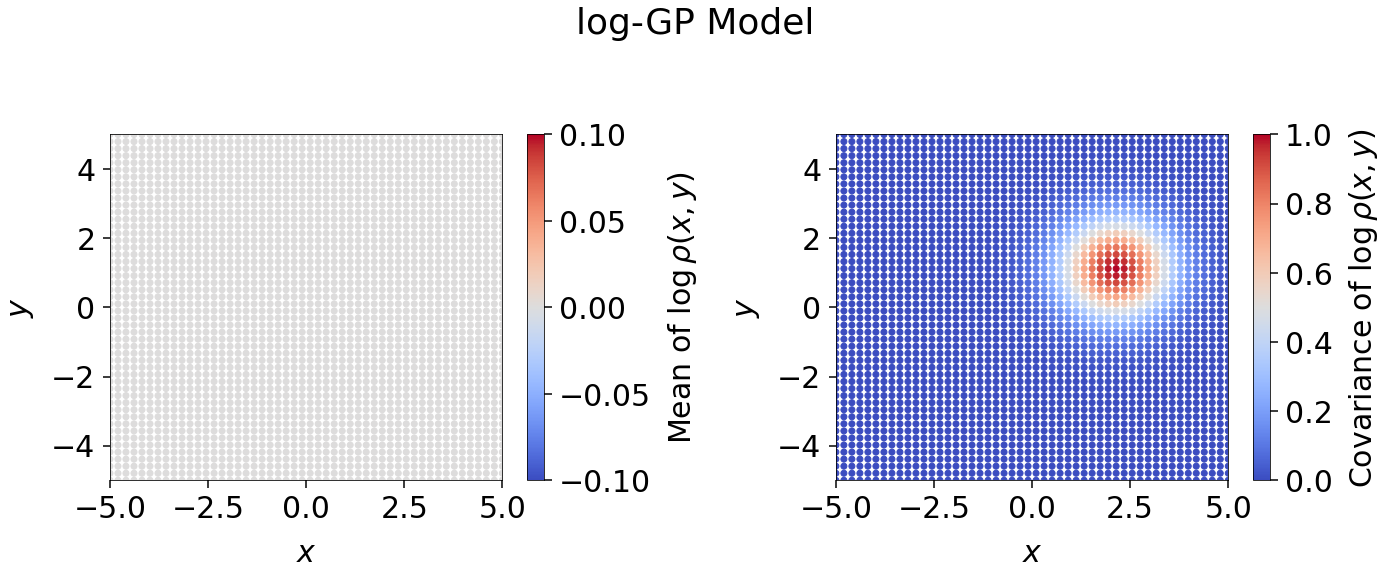

In [7]:
idx = 1780

# plot mean and cov 
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=Ygrid_mean, 
            cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'Mean of $\log \rho(x, y)$')
plt.xlim([xgrid[0], xgrid[-1]])
plt.ylim([ygrid[0], ygrid[-1]])
plt.subplot(1, 2, 2)
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=Ygrid_cov[idx], 
            cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'Covariance of $\log \rho(x, y)$')
plt.xlim([xgrid[0], xgrid[-1]])
plt.ylim([ygrid[0], ygrid[-1]])
plt.suptitle('log-GP Model', y=1.03)
plt.tight_layout()

We can also generate data realizations from our log-GP as well. We'll generate some data and then plot our log-GP realization below. If you rerun the sampling process below without fixing the random state, you'll find that these realizations can change quite a bit!

In [8]:
# generate a realization of the log-GP at location of the inputs
# set random_state to a number to get deterministic results
Ygrid_samps = gp.sample_y(Xgrid, random_state=2021).reshape(len(Xgrid))

(2500,)


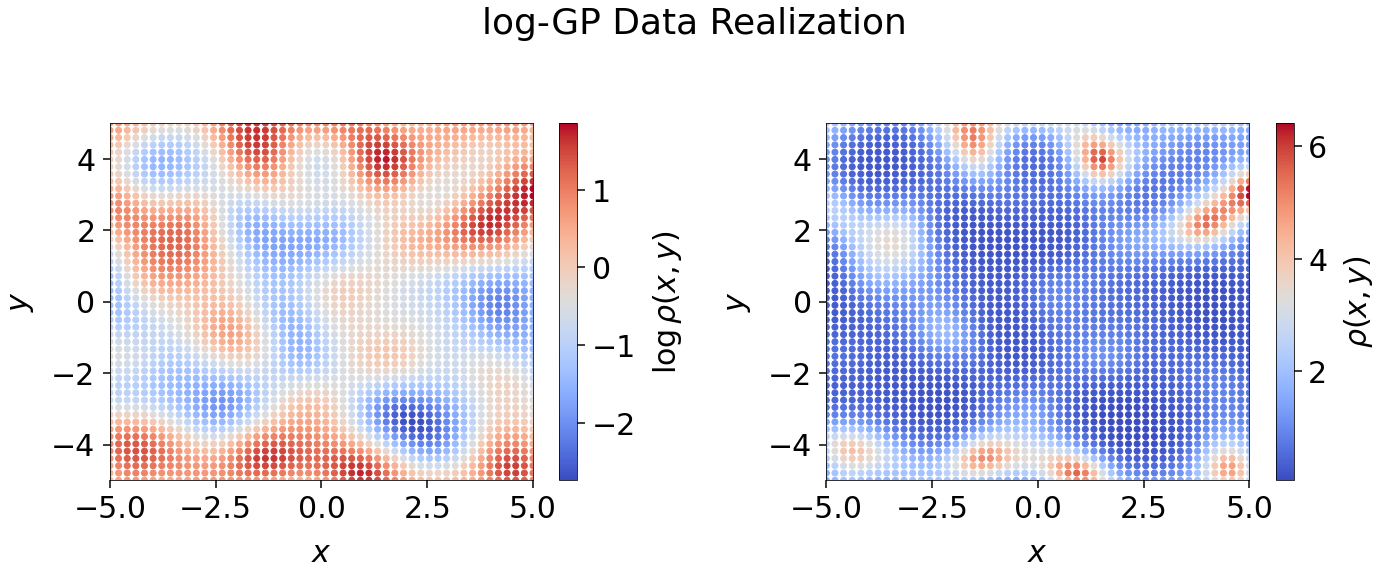

In [9]:
# plot realization 
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=Ygrid_samps, 
            cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\log \rho(x, y)$')
plt.xlim([xgrid[0], xgrid[-1]])
plt.ylim([ygrid[0], ygrid[-1]])
plt.subplot(1, 2, 2)
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=np.exp(Ygrid_samps), 
            cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\rho(x, y)$')
plt.xlim([xgrid[0], xgrid[-1]])
plt.ylim([ygrid[0], ygrid[-1]])
plt.suptitle('log-GP Data Realization', y=1.03)
plt.tight_layout()
print(Ygrid_samps.shape)
plt.savefig('datarealization.png')

This will define our fiducial model for the underlying distribution of dust. To make this a continuous function, we'll **smoothly interpolate** the data using a [**thin plate spline**](https://en.wikipedia.org/wiki/Thin_plate_spline).

In [10]:
from scipy import interpolate
logdust = interpolate.Rbf(Xgrid[:, 0], Xgrid[:, 1], Ygrid_samps, 
                          function='thin_plate',  # specific interpolation method
                          smooth=0)  # smoothing parameter (0=exact fit)

# Simulating Observations

To simulate observations, we will assume that stars are randomly distributed throughout space and that they trace the underlying density field. We'll want to separate out the sample into training, validation, and testing sets too. (If you have time, you can also explore more complicated options such as, e.g., switching out the fixed validation set for a full [k-fold cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) framework.)

We are ultimately interested in coming up with a function $f(\mathbf{x})$ based on our training data $\mathbf{X}_{\rm train} = \{ \mathbf{x}_1, \dots, \mathbf{x}_{n} \}$ and observations $\mathbf{Y}_{\rm train} = \{ y(\mathbf{x}_1), \dots, y(\mathbf{x}_n) \}$ that will hopefully be a good approximation to the underyling dust density field $\rho(\mathbf{x})$ or it's logarithmic equivalent $\log\rho(\mathbf{x})$.

## Intrinsic Values (Log-Dust)

To start, we will assume that we have no measurement errors in either the positions $\mathbf{x}$ or the outputs $y(\mathbf{x})$, and that the output is just the log-dust density so $y(\mathbf{x}) = \log \rho(\mathbf{x})$. 

In [27]:
# simulate stars
n_stars = 10000  # with more stars, our model should get better

X = np.random.uniform(-5, 5, size=(n_stars, 2))  # true positions
X_err = np.random.uniform(0.1, 0.3, size=(n_stars, 2)) 
X_obs = np.random.normal(X, X_err)  # noisy realization of shape (n_stars, 2)
X_obs_samps = np.array([[np.random.normal(X_obs[j], X_err[j]) for i in range(10)] for j in range(n_stars)])  # samples based on the noisy observation and associated error, 
                                                                             # of shape (10, n_stars, 2)
# make corrections for X_obs: X values may end up out of the grid which causes errors when putting them in bins
# for i in range(len(X_obs_samps)):
#     for j in range(10):
#         for z in range(2):
#             if X_obs_samps[i][j][z] > 5:
#                 X_obs_samps[i][j][z] = 5 - 1e-6
#             if X_obs_samps[i][j][z] < -5:
#                 X_obs_samps[i][j][z] = -5 + 1e-6
# print(len(X_obs_samps))
# X_obs = np.copy(X)  # observed positions
# X_err = np.zeros_like(X_obs)  # scatter/measurement errors

# evaluate positions over our log-dust density field
Y = logdust(X[:, 0], X[:, 1])  # intrinsic values
Y_err = np.random.uniform(0.2, 0.4, len(Y)) # error bar is 0.3 to 0.5
Y_obs = np.random.normal(Y, Y_err) # selects data 0.1 or less away from Yo_test value if error_bar = 0.1. error_bar is standard dev: 
# Y_obs = np.copy(Y)  # observed values: even though we choose the y(x)=logp(x) the intrinsic (realistic) values we look
                      # for are not logp(x) but p(x), even better the integration but for simplicity we get y(x)=logpx same as obs from training
                      #yobs finds ys using prior GP
# Y_err = np.zeros_like(Y_obs)  # scatter/measurement errors

# training/validation/testing splits
f_train, f_valid = 0.6, 0.2
f_test = 1. - f_train - f_valid
idx_train, idx_valid = int(n_stars * f_train), int(n_stars * (f_train + f_valid))

# split data
X_train, X_valid, X_test = X[:idx_train], X[idx_train:idx_valid], X[idx_valid:]
Xo_train, Xo_valid, Xo_test = X_obs[:idx_train], X_obs[idx_train:idx_valid], X_obs[idx_valid:]
Xo_samp_train, Xo_samp_valid, Xo_samp_test = X_obs_samps[:idx_train], X_obs_samps[idx_train:idx_valid], X_obs_samps[idx_valid:]
Xe_train, Xe_valid, Xe_test = X_err[:idx_train], X_err[idx_train:idx_valid], X_err[idx_valid:]
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]
Yo_train, Yo_valid, Yo_test = Y_obs[:idx_train], Y_obs[idx_train:idx_valid], Y_obs[idx_valid:]
Ye_train, Ye_valid, Ye_test = Y_err[:idx_train], Y_err[idx_train:idx_valid], Y_err[idx_valid:]

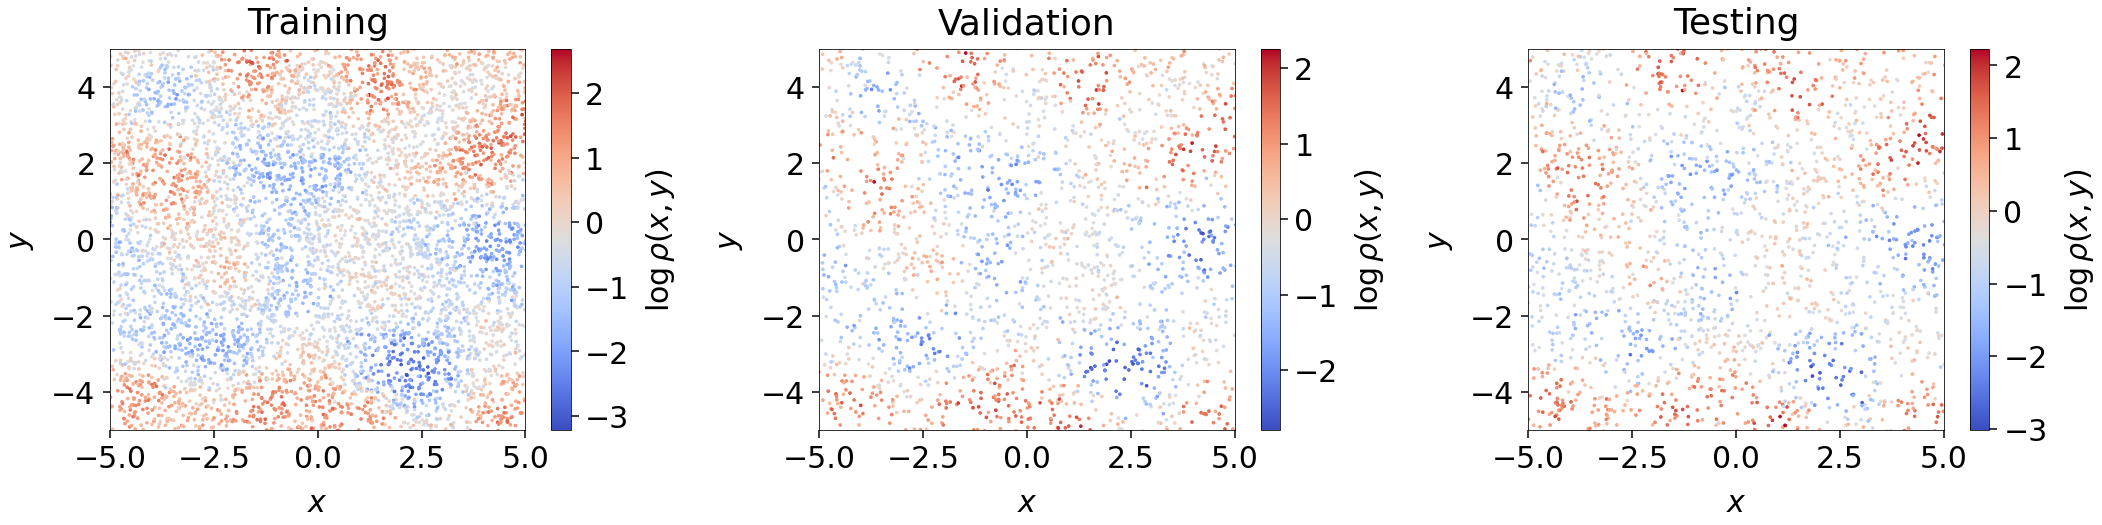

In [28]:
# plot data
plt.figure(figsize=(30, 8))
plt.subplot(1, 3, 1)
plt.scatter(Xo_train[:, 0], Xo_train[:, 1], c=Yo_train, 
            cmap='coolwarm', s = 7)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\log \rho(x, y)$')
plt.xlim([xgrid[0], xgrid[-1]])
plt.ylim([ygrid[0], ygrid[-1]])
plt.title('Training')
plt.subplot(1, 3, 2)
plt.scatter(Xo_valid[:, 0], Xo_valid[:, 1], c=Yo_valid, 
            cmap='coolwarm', s = 7)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\log \rho(x, y)$')
plt.xlim([xgrid[0], xgrid[-1]])
plt.ylim([ygrid[0], ygrid[-1]])
plt.title('Validation')
plt.subplot(1, 3, 3)
plt.scatter(Xo_test[:, 0], Xo_test[:, 1], c=Yo_test, 
            cmap='coolwarm', s = 7)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\log \rho(x, y)$')
plt.xlim([xgrid[0], xgrid[-1]])
plt.ylim([ygrid[0], ygrid[-1]])
plt.title('Testing')
plt.tight_layout()
plt.savefig('training-test-valid.png')

Our function $f(x)$ will try to approximate $\log \rho(\mathbf{x})$ directly.

## Intrinsic Values (Dust)

Now, rather than assume we have measurements of the log-dust, we will assume that we have measurements of the actual dust instead such that $y(\mathbf{x}) = \rho(\mathbf{x})$.

In [13]:
# modify the intrinsic data Y above to define all corresponding
# values to be equal to dust rather than log-dust

# also remember to copy over to Y_obs!

In [29]:
# re-define data splits
X_train, X_valid, X_test = X[:idx_train], X[idx_train:idx_valid], X[idx_valid:]
Xo_train, Xo_valid, Xo_test = X_obs[:idx_train], X_obs[idx_train:idx_valid], X_obs[idx_valid:]
Xo_samp_train, Xo_samp_valid, Xo_samp_test = X_obs_samps[:idx_train], X_obs_samps[idx_train:idx_valid], X_obs_samps[idx_valid:]
Xe_train, Xe_valid, Xe_test = X_err[:idx_train], X_err[idx_train:idx_valid], X_err[idx_valid:]
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]
Yo_train, Yo_valid, Yo_test = Y_obs[:idx_train], Y_obs[idx_train:idx_valid], Y_obs[idx_valid:]
Ye_train, Ye_valid, Ye_test = Y_err[:idx_train], Y_err[idx_train:idx_valid], Y_err[idx_valid:]

In [30]:
# plot data

Our function $f(x)$ will now try to approximate $\rho(\mathbf{x})$ rather than $\log \rho(\mathbf{x})$.

## Intrinsic Values (Integrated Dust)

In practice, stars don't actually trace the actual values of the dust, but rather than the **integrated dust** along a given **line of sight**. In other words, what we actually have access to is

$$ y(\mathbf{x}_i) \equiv y_i = \int_{0}^{r_i} \rho(\mathbf{x}_0 + r \times \hat{\boldsymbol{\ell}}_i) \,{\rm d}r $$

where $\mathbf{x}_0$ is our current position, $r_i = ||\mathbf{x}_i - \mathbf{x}_0||$ is the distance between us and the source, and $\hat{\boldsymbol{\ell}}_i = (\mathbf{x}_i - \mathbf{x}_0) / r_i$ is the normalized direction vector.

Without loss of generality, let's assume that we are located at the center such that $\mathbf{x}_0 = \mathbf{0}$.

In [31]:
# modify the intrinsic data Y above to define all corresponding
# values to be equal to the integrated dust you will need 
# to compute the integral above numerically for every data point,
# and test that the numerical precision is good to 1e-5

# also remember to copy over to Y_obs!

In [32]:
# re-define data splits
X_train, X_valid, X_test = X[:idx_train], X[idx_train:idx_valid], X[idx_valid:]
Xo_train, Xo_valid, Xo_test = X_obs[:idx_train], X_obs[idx_train:idx_valid], X_obs[idx_valid:]
Xo_samp_train, Xo_samp_valid, Xo_samp_test = X_obs_samps[:idx_train], X_obs_samps[idx_train:idx_valid], X_obs_samps[idx_valid:]
Xe_train, Xe_valid, Xe_test = X_err[:idx_train], X_err[idx_train:idx_valid], X_err[idx_valid:]
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]
Yo_train, Yo_valid, Yo_test = Y_obs[:idx_train], Y_obs[idx_train:idx_valid], Y_obs[idx_valid:]
Ye_train, Ye_valid, Ye_test = Y_err[:idx_train], Y_err[idx_train:idx_valid], Y_err[idx_valid:]

In [33]:
# plot data

Because our data are now in these integrated coordinates, our function $f(\mathbf{x})$ now traces the integrated dust. As a result, to get back to the underlying dust density field we will need to differentiate $f(\mathbf{x})$ with respect to $r$, i.e.

$$ \rho(\mathbf{x}) \approx \frac{\partial f(\mathbf{x})}{\partial r} $$

## Uncertain Values (Integrated Dust)

Now, let's modify our observations to include uncertainty (measurement noise, scatter, etc.). In practice, we don't actually observe $y_i = y(\mathbf{x}_i)$ directly at a given position $\mathbf{x}_i$, but rather a noisy realization $\tilde{y}_i$ associated with a given measurement error $\sigma_i$. More formally, our model will be:

$$\tilde{y}_i \sim \mathcal{N}(y_i, \sigma_i)$$

This means that the noisy measurement $\tilde{y}_i$ is distributed following a Normal distribution $\mathcal{N}(\mu,\sigma)$ with mean $\mu=y_i$ (the true, intrinsic value) and standard deviation $\sigma=\sigma_i$ (which we assume is known). Alternately, we could write the probability distribution for $\tilde{y}_i$ as

$$ P(\tilde{y}_i | \mathbf{y}_i, \sigma_i) = \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\frac{(\tilde{y}_i - y_i)^2}{\sigma_i^2}\right)$$

where the $|$ stands for "given" or "conditioned on". The normalization constant out front just guarantees that the integral over all possible values of $\tilde{y}_i$ (or by symmetry $y_i$) equals 1.

We will want to take these errors into account when deriving our function $f(\mathbf{x})$, since points with larger errors give more uncertain estimates of the integrated dust at a given position than points with small errors.

In [34]:
# define the measurement errors Y_err to be non-zero
# assuming that our errors are uniformly distributed
# between 0.2 and 0.5, then simulate the
# noisy observations Y_obs based on these errors

In [35]:
# re-define data splits
X_train, X_valid, X_test = X[:idx_train], X[idx_train:idx_valid], X[idx_valid:]
Xo_train, Xo_valid, Xo_test = X_obs[:idx_train], X_obs[idx_train:idx_valid], X_obs[idx_valid:]
Xo_samp_train, Xo_samp_valid, Xo_samp_test = X_obs_samps[:idx_train], X_obs_samps[idx_train:idx_valid], X_obs_samps[idx_valid:]
Xe_train, Xe_valid, Xe_test = X_err[:idx_train], X_err[idx_train:idx_valid], X_err[idx_valid:]
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]
Yo_train, Yo_valid, Yo_test = Y_obs[:idx_train], Y_obs[idx_train:idx_valid], Y_obs[idx_valid:]
Ye_train, Ye_valid, Ye_test = Y_err[:idx_train], Y_err[idx_train:idx_valid], Y_err[idx_valid:]

In [36]:
# plot data

## Uncertain Values (Integrated Dust & Distance)

In practice, things are even worse than the previous case: not only do we not have an accurate estimate of the integrated dust, but we *also* don't have an accurate estimate of the **distance** $r_i$ to the source. Since astronomers can most often estimate a source's position on the sky relatively accurately, we don't usually don't have to consider additional positional errors outside of those on $r_i$.

A reasonable model for these uncertainties is to assume that the measured distance $\tilde{r}_i$ relates to the true distance $r_i$ based on a fractional uncertainty $s_i$ such that

$\tilde{r}_i \sim \mathcal{N}(r_i, s_i \times r_i)$

This translates into a new observed position

$$ \tilde{x}_i = \mathbf{x}_0 + \tilde{r}_i \times \hat{\boldsymbol{\ell}}_i $$

Together, this now gives both a noisy measurement of the position $\tilde{x}_i$ and a noisy measurement of the integrated dust $\tilde{y}_i = \tilde{y}(\mathbf{x}_i)$ *relative to the true position*.

In [37]:
# define the measurement errors X_err to be non-zero
# assuming that our fractional uncertainties are uniformly distributed
# between 0.02 and 0.2, then simulate the
# noisy observations X_obs based on these errors
# (note that you do not need to recompute any of the previous integrals)

In [38]:
# re-define data splits
X_train, X_valid, X_test = X[:idx_train], X[idx_train:idx_valid], X[idx_valid:]
Xo_train, Xo_valid, Xo_test = X_obs[:idx_train], X_obs[idx_train:idx_valid], X_obs[idx_valid:]
Xo_samp_train, Xo_samp_valid, Xo_samp_test = X_obs_samps[:idx_train], X_obs_samps[idx_train:idx_valid], X_obs_samps[idx_valid:]
Xe_train, Xe_valid, Xe_test = X_err[:idx_train], X_err[idx_train:idx_valid], X_err[idx_valid:]
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]
Yo_train, Yo_valid, Yo_test = Y_obs[:idx_train], Y_obs[idx_train:idx_valid], Y_obs[idx_valid:]
Ye_train, Ye_valid, Ye_test = Y_err[:idx_train], Y_err[idx_train:idx_valid], Y_err[idx_valid:]

In [39]:
# plot data

We will want to take both sets of errors into account when trying to derive our function $f(\mathbf{x})$, as they can impact the fidelity of our final estimates in slightly different ways.

# Save Data

We want to use the training, validation, and testing data to develop and compare various methods. We'll also want to save a copy of the input model data that we use to generate our dataset. For reproducibility, you should plan to save the outputs each time you make changes to the underlying model of the dust density field and/or the simulated observations. These should also be given a unique name/identifier.

In [40]:
# save data
np.savez('logdust_noisy.npz',  # filename example
         Xgrid=Xgrid, logdust_grid=Ygrid_samps,  # model grid
         X_train=X_train, X_valid=X_valid, X_test=X_test,  # locations (true)
         Xo_train=Xo_train, Xo_valid=Xo_valid, Xo_test=Xo_test,  # locations (measured)
         Xo_samp_train=Xo_samp_train, Xo_samp_valid=Xo_samp_valid, Xo_samp_test=Xo_samp_test,  #locations (sampled)
         Xe_train=Xe_train, Xe_valid=Xe_valid, Xe_test=Xe_test,  # locations (error)
         Y_train=Y_train, Y_valid=Y_valid, Y_test=Y_test,  # dust (true)
         Yo_train=Yo_train, Yo_valid=Yo_valid, Yo_test=Yo_test,  # dust (measured)
         Ye_train=Ye_train, Ye_valid=Ye_valid, Ye_test=Ye_test)  # dust (error)
print(Xo_samp_train)

[[[-4.35430674  2.89138241]
  [-3.97186721  2.74396205]
  [-4.05480977  2.87800614]
  ...
  [-4.30047058  2.92319313]
  [-4.14433125  2.94677377]
  [-3.96312717  3.15930832]]

 [[ 1.33820218  3.3771846 ]
  [ 0.85347611  2.95379649]
  [ 0.99715241  3.54663004]
  ...
  [ 1.49236135  3.05312332]
  [ 1.2337915   3.10837718]
  [ 1.04686534  3.44833238]]

 [[ 3.57943679  1.1549566 ]
  [ 3.41432776  1.3625566 ]
  [ 3.40647357  1.22521362]
  ...
  [ 3.72416674  1.33732267]
  [ 4.14715507  1.421747  ]
  [ 3.85244746  1.23104824]]

 ...

 [[ 0.02192456 -4.78420621]
  [-0.44545986 -4.8445574 ]
  [-0.39247544 -4.66839707]
  ...
  [-0.41689696 -4.20232668]
  [-0.24431897 -4.73256222]
  [-0.4356064  -4.20816961]]

 [[ 1.57655374 -0.04918394]
  [ 1.22334711  0.34030999]
  [ 2.06357106  0.10710069]
  ...
  [ 1.09595882 -0.19669172]
  [ 1.04756547  0.51223368]
  [ 1.47372401  0.28881869]]

 [[ 0.97008021 -2.00731322]
  [ 0.85143808 -2.63977304]
  [ 0.77801873 -2.64332216]
  ...
  [ 0.89137612 -2.295001

## Error bars and Data Perturbation: Loss vs Number of Bins

In [26]:
# # same code as before but with data perturbed: !!! make a function instead of copyin code
# error_bar = np.random.uniform(ERROR_BAR_LOW, ERROR_BAR_HIGH, len(Yo_test))
# data_perturbed = np.random.normal(Yo_test, error_bar) # selects data 0.1 or less away from Yo_test value if error_bar = 0.1. error_bar is standard dev: 
#                                                                                                         #Zhow spread out that dust density is located
# bin_model_lst, loss_lin_vals, loss_asinh_vals = plot_loss_bin_model(1, 100, Xo_test, data_perturbed)
# print(loss_lin_vals[-5: -1])